<a target="_blank" href="https://colab.research.google.com/github/lucky-verma/information-retrieval/blob/main/ir_synthetic_data_rag_rerank_fine_tune.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# AWS Case Studies and Blogs Information Retrieval System

## Project Overview

This project aims to develop an advanced information retrieval system specifically designed for AWS case studies and blogs. Our goal is to create a robust solution that can efficiently fetch the most relevant documents from a large corpus of AWS-related articles and generate accurate responses to user queries based on the retrieved context.

Key components of this project include:

1. Data Preparation: We use a curated dataset of AWS case studies and blogs, available on Kaggle (<https://www.kaggle.com/datasets/harshsinghal/aws-case-studies-and-blogs>). This dataset serves as the foundation for our information retrieval system.

2. Embedding Generation: We utilize state-of-the-art sentence transformer models to generate high-quality embeddings for our document chunks, enabling efficient similarity search.

3. Vector Storage: We implement ChromaDB for vector storage in our development environment, with considerations for scaling to pgvector in a production setting.

4. Retrieval and Reranking: Our system employs a two-stage retrieval process, using initial similarity search followed by a cross-encoder model for reranking to improve result relevance.

5. Synthetic QA Dataset Generation: To enhance our model's performance, we generate a synthetic question-answer dataset saved on Hugging Face (https://huggingface.co/datasets/thinkersloop/aws-case-studies-and-blogs-short) using advanced language models.

6. Model Fine-Tuning: We fine-tune a LoRA adapter on the LLaMA 3 8B model (https://huggingface.co/thinkersloop/llama-3-8b-bnb-4bit) to specialize in AWS-related queries and responses.

7. Evaluation: We implement a evaluation strategy to assess the performance of our information retrieval and question-answering system.


This notebook walks through the entire process, from data preparation to model deployment, providing a comprehensive guide to building a sophisticated information retrieval and question-answering system for AWS-related content.


# Setup and Data Loading

##### Installing Packages

In [1]:
%%capture

!pip install tiktoken
!pip install transformers
!pip install accelerate
!pip install bitsandbytes
!pip install datasets
!pip install py7zr
!pip install chromadb
!pip install sentence_transformers
!pip install langchain_community
!pip install gradio pydantic
!pip install gradio
!pip install -q -U google-generativeai
!pip install rouge-score

In [122]:
# running on gpu
import torch

if torch.cuda.is_available():
    device = torch.device('cuda:0')

torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)

##### Load Kaggle dataset

In [3]:
%%capture

# Please add required keys in colab
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d harshsinghal/aws-case-studies-and-blogs
!mkdir data/
!unzip "aws-case-studies-and-blogs.zip" -d data/

In [4]:
# dataset path
dataset_path = './data/'

# Data Preparation

## Sentence Chunking and Document Processing
My data preparation process focuses on efficient text processing and chunking:
- Uses SpaCy for NLP tasks and custom sentence-based chunking
- Cleans text and Assigns unique IDs and metadata (source, topic) to each chunk
- Outputs LangChain-compatible Document objects

This approach offers fine-grained control over the text processing pipeline, crucial for optimizing vector storage and retrieval.


In [5]:
import spacy
import torch
import uuid

from typing import List, Dict
from transformers import pipeline
from langchain.schema import Document

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading en_core_web_sm model...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def clean_text(text: str) -> str:
    return ' '.join(token.text for token in nlp(text) if not token.is_space)

def is_case_study(file_name: str) -> bool:
    return "case study" in file_name.lower()

def process_chunk(text: str, source: str, topic: str) -> Dict:
    cleaned_text = clean_text(text)

    metadata = {
        "source": source,
        "topic": topic
    }
    return {
        "id": str(uuid.uuid4()),
        "text": cleaned_text,
        "metadata": metadata
    }

def process_file(file_path: str, chunk_size: int = 500, chunk_overlap: int = 100) -> List[Dict]:
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Calculate the topic using the file name
    # TODO: We can use Zero-shot classification, if we want more tags
    file_name = os.path.basename(file_path)
    is_case_study_file = is_case_study(file_name)
    file_topic = "case-study" if is_case_study_file else "blog"

    chunks = []
    doc = nlp(content)
    current_chunk = []
    current_size = 0

    for sent in doc.sents:
        sentence_size = len(sent.text)
        if current_size + sentence_size > chunk_size and current_chunk:
            chunks.append(process_chunk(" ".join(current_chunk), file_path, file_topic))
            overlap_size = 0
            while overlap_size < chunk_overlap and current_chunk:
                overlap_size += len(current_chunk[0])
                current_chunk = current_chunk[1:]
            current_size = sum(len(s) for s in current_chunk)
        current_chunk.append(sent.text)
        current_size += sentence_size

    if current_chunk:
        chunks.append(process_chunk(" ".join(current_chunk), file_path, file_topic))

    return chunks


def process_folder(folder_path: str, chunk_size: int = 500, chunk_overlap: int = 100) -> List[Dict]:
    all_documents = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            try:
                documents = process_file(file_path, chunk_size=chunk_size, chunk_overlap=chunk_overlap)

                # Create documents for each chunk
                for doc in documents:
                    all_documents.append(Document(page_content=doc['text'],
                                                  metadata=doc['metadata']))
            except Exception as e:
                print(f"Error processing file {file_path}: {str(e)}")

    return all_documents


In [6]:
# Process folder with txt files
split_docs = process_folder(dataset_path)
print(f"\nLoaded {len(split_docs)} document chunks")


Loaded 16667 document chunks


In [7]:
split_docs[0].metadata

{'source': './data/6sense Case Study.txt', 'topic': 'case-study'}

In [8]:
split_docs[0].page_content

'Searching for a more scalable solution , 6sense began to explore Kubernetes , an open - source container orchestration system , to improve its data pipelines . In 2018 , the company migrated its application and API services to two Kubernetes clusters and began using kOps , a set of tools for installing , operating , and deleting Kubernetes clusters in the cloud .'

# Embedding Generation & Vector Store

## Generate embeddings using Sentence Transformers

Now, let's use a pre-trained Sentence Transformer model to generate embeddings:

The all-MiniLM-L6-v2 model is an excellent choice for sentence embeddings due to its balance of performance and efficiency. This model offers high-quality embeddings while being relatively small and fast, making it suitable for various applications. It performs well on semantic similarity tasks and can handle multiple languages, making it versatile for different use cases. The model's compact size also allows for easier deployment and reduced computational requirements, making it an attractive option for projects with resource constraints or those requiring quick processing times.


In [25]:
from langchain.embeddings import HuggingFaceEmbeddings

# Initialize all-MiniLM-L6-v2 model
embed_model_name = "all-MiniLM-L6-v2"
model_kwargs = {"device": "cuda:0"}
encode_kwargs = {"normalize_embeddings": True}
embed_model = HuggingFaceEmbeddings(
    model_name=embed_model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

In [26]:
embed_model

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={'device': 'cuda:0'}, encode_kwargs={'normalize_embeddings': True}, multi_process=False, show_progress=False)

## Fine-Tune Embedding Model on our dataset

In [462]:
import numpy as np
from sentence_transformers import InputExample
import random

def create_training_examples(documents, pos_pairs_per_doc=5, neg_pairs_per_doc=5):
    examples = []
    all_sentences = []
    doc_boundaries = [0]

    # Pre-process all documents
    for doc in documents:
        sentences = doc.page_content.split('. ')
        all_sentences.extend(sentences)
        doc_boundaries.append(len(all_sentences))

    all_sentences = np.array(all_sentences)

    for i in range(len(documents)):
        start, end = doc_boundaries[i], doc_boundaries[i+1]
        doc_sentences = all_sentences[start:end]

        # Positive pairs
        if len(doc_sentences) > 1:
            pos_pairs = np.random.choice(len(doc_sentences), size=(pos_pairs_per_doc, 2), replace=True)
            for pair in pos_pairs:
                examples.append(InputExample(texts=[doc_sentences[pair[0]], doc_sentences[pair[1]]], label=1.0))

        # Negative pairs
        for _ in range(neg_pairs_per_doc):
            other_doc_idx = np.random.choice([j for j in range(len(documents)) if j != i])
            other_start, other_end = doc_boundaries[other_doc_idx], doc_boundaries[other_doc_idx+1]
            other_sentence = np.random.choice(all_sentences[other_start:other_end])
            examples.append(InputExample(texts=[np.random.choice(doc_sentences), other_sentence], label=0.0))

    return examples

train_examples = create_training_examples(split_docs)

In [2]:
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from sentence_transformers import losses

# Initialize the embedding model for training
base_embed_model = SentenceTransformer('all-MiniLM-L6-v2')
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(base_embed_model)

# Fine-tune the model
base_embed_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10)

# Save the fine-tuned model
base_embed_model.save('fine_tuned_aws_embeddings')

Step,Training Loss
500,2.310000
1000,2.138900
1500,2.151300
2000,2.132400
2500,2.121400
3000,2.096700
3500,2.058800
4000,2.086400
4500,2.083900
5000,2.086700


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [12]:
# load the embedding model
original_model = SentenceTransformer('all-MiniLM-L6-v2')
fine_tuned_model = SentenceTransformer('fine_tuned_aws_embeddings')

test_docs = split_docs[-100:]  # Use the last 100 documents as a test set
test_queries = ["What did 6Sense use for scaling?", "How Rivian uses AWS?"]


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_documents(model, query, documents, top_k=5):
    query_embedding = model.encode([query])[0]
    doc_embeddings = model.encode([doc.page_content for doc in documents])
    similarities = cosine_similarity([query_embedding], doc_embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [(documents[i], similarities[i]) for i in top_indices]

def evaluate_retrieval(model, queries, documents):
    for query in queries:
        print(f"Query: {query}")
        retrieved_docs = retrieve_documents(model, query, documents)
        for i, (doc, similarity) in enumerate(retrieved_docs, 1):
            print(f"Top {i} document (similarity: {similarity:.4f}): {doc.page_content[:42]}...")
        print("\n")

print('-' * 83)
print("Original Model Retrieval:")
print('-' * 83)
evaluate_retrieval(original_model, test_queries, test_docs)
print('-' * 83)
print("Fine-tuned Model Retrieval:")
print('-' * 83)
evaluate_retrieval(fine_tuned_model, test_queries, test_docs)

-----------------------------------------------------------------------------------
Original Model Retrieval:
-----------------------------------------------------------------------------------
Query: What did 6Sense use for scaling?
Top 1 document (similarity: 0.2303): The team uses Service Workbench on AWS to ...
Top 2 document (similarity: 0.2152): “ The ability to scale resources dynamical...
Top 3 document (similarity: 0.2113): Using Optimizing for Efficiency and Innova...
Top 4 document (similarity: 0.2113): Typically , these datasets are large and s...
Top 5 document (similarity: 0.2001): Researchers can securely access large data...


Query: How Rivian uses AWS?
Top 1 document (similarity: 0.8009): It is designed to make web - scale cloud c...
Top 2 document (similarity: 0.7966): Contact our experts and start your own AWS...
Top 3 document (similarity: 0.7966): Rivian pushes the pace of automotive innov...
Top 4 document (similarity: 0.7534): The company uses Using the Breadth 

You can see scores are better with Fine-Tune embedding model

## Set up Chroma and embed documents using `fine_tuned_model`

I chose ChromaDB for my project because it's lightweight, easy to set up, and perfect for quick prototyping in my Jupyter notebook. It doesn't require a separate database server, which simplifies my development process.

However, for a production environment with 4x A100 GPUs serving 1000 users daily, I'd opt for PostgreSQL with pgvector. It offers better scalability, concurrent access, and ACID compliance. PG Vector can handle larger datasets and more complex queries efficiently, which is crucial for high-performance production systems. Plus, it integrates well with existing PostgreSQL infrastructure, making it easier to manage and maintain in a production setting.

Now, let's set up Chroma as our vector store and embed the documents:


In [41]:
from langchain.embeddings import HuggingFaceEmbeddings

# Initialize the fine tuned embedding model
fine_tuned_embed_model = HuggingFaceEmbeddings(
    model_name='fine_tuned_aws_embeddings',
    model_kwargs={"device": "cuda:0"},
    encode_kwargs={"normalize_embeddings": True}
)

In [47]:
from langchain.vectorstores import Chroma

# Create a Chroma vector store
db = Chroma.from_documents(
    documents=split_docs,
    embedding=fine_tuned_embed_model,
    persist_directory="./db_chroma"
)

# Persist the database
db.persist()

# Retrieval and Reranking

#### ReRanker using Cross Encoder model

In [48]:
from sentence_transformers.cross_encoder import CrossEncoder

# Initiating Cross-Encoder Model for reranking top documents
cross_encoder_model = CrossEncoder('sentence-transformers/all-mpnet-base-v2')

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# Method to find top Documents

def find_top_docs(question, db_collection, cross_encoder_model, embed_model, top_k=4):

    """
    Find the top-k documents matching the query and also send the most suitable
    document after re-ranking depending on the input question.

      Args:
          question (str): The Question from user.
          db_collection (collection): object with embeddings for all the text chunks.
          cross_encoder_model (CrossEncoder): Model for reranking top documents found in initial search result.
          embed_model(HuggingFaceBgeEmbeddings): Model for embedding all text chunks
          top-k (int): Number of chunks most related to the query.

      Returns:
          str: most suitable document depending on the input question.

    """

    qembed= embed_model.embed_query(question)
    result = db_collection.similarity_search_with_score(question, k=top_k)

    # Unpack the tuples and keep both document content and initial scores
    top_docs_list = [(doc.page_content, score) for doc, score in result]

    cross_input = [[question, docs[0]] for docs in top_docs_list]
    cross_scores = list(cross_encoder_model.predict(cross_input))

    # Combine the cross-encoder scores, initial scores, and docs
    combined = sorted(zip(cross_scores, [score for _, score in top_docs_list], [content for content, _ in top_docs_list]), reverse=True)

    # Extract the sorted docs
    sorted_docs = [docs for _, _, docs in combined]

    return sorted_docs[0], combined



In [117]:
find_top_docs("What did 6Sense use for scaling?", db, cross_encoder_model, fine_tuned_embed_model)[1]

[(0.50038254,
  0.8282816410064697,
  '6sense Insights Inc. ( 6sense ) needed to effectively scale and manage its data pipelines so that it could better support its growth . With 6sense Revenue AI , a leading platform for predictable revenue growth , the company generates actionable insights for business - to - business sales and marketing teams . This service relies on artificial intelligence , machine learning , and big data processing , requiring 6sense to run complex workloads and process terabytes of data per day .'),
 (0.49956676,
  0.9839830994606018,
  'Headquartered in San Francisco , California , 6sense delivers data analytics , sales insights , and other predictions so that business - to - business revenue teams can better understand their buyers and customers . In 2014 , the company began using Apache Mesos , an open - source solution that manages compute clusters , to orchestrate its data pipeline frameworks . “ As we grew , we encountered several limitations on Apache Mes

# Synthetic QA Dataset Generation

## Using Gemini model for QA pair generation

We have ~16000 chunks of data. To create a 5 question-answer pair for each chunk with a prompt of 500 tokens, we would need approximately need 17hrs to create a dataset because of Gemini rate limit of Free tier: 15 RPM (requests per minute), 1,500 RPD(requests per day)

We'll generate data for 1000 chunks which should take around 1hr.

NOTE: We can add temperature range (maybe 0.1 to 1.2) to generate a wide variety of QA pairs

In [4]:
import pathlib
import textwrap

import google.generativeai as genai
from google.colab import userdata

from IPython.display import display
from IPython.display import Markdown

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-001
models/gemini-1.5-flash-latest
models/gemini-1.5-pro
models/gemini-1.5-pro-001
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


In [5]:
model = genai.GenerativeModel('gemini-1.5-flash-latest')

In [6]:
qa_gen_prompt= """

<input-text>

{}

<input-text>

Provide 5 question and answer pair(s) based on the text above. The question should include sufficient information for the answer, without the user having any further context. The answers need not necessarily borrow verbatim from the input text, but they should maintain the meaning. Vary the style and format of questions. Include some tricky and nuanced questions. In certain answers, reverse the order of words compared to how they appear in the input text. Respond in plain text on a new line for each question and answer. Do not include question numbers. Please follow the given formart here in the example question answer pair:

<example-start>
What cloud services does 54gene use to store and visualize its datasets?
54gene uses Amazon Relational Database Service (Amazon RDS) to store and visualize its datasets.

How does 54gene utilize Amazon Elastic Compute Cloud (Amazon EC2) in its operations?
54gene uses Amazon Elastic Compute Cloud (Amazon EC2) to power its data analytics workflows, enabling it to analyze large datasets efficiently and achieve significant throughput while reducing costs.
<example-end>
"""

In [7]:
test_data = """54gene stores all its genomic data using Amazon Simple Storage Service (Amazon S3), object storage built to retrieve any amount of data from anywhere. “Another great aspect of working on AWS is that we can configure data storage to be cost effective,” says Joshi. The company uses Amazon S3 Lifecycle policies to automatically migrate data to Amazon S3 Glacier storage classes—which are purpose-built for data archiving—to minimize storage costs.  To conveniently access data stored in Amazon S3 for processing using HPC clusters, the startup uses Amazon FSx for Lustre, which provides fully managed shared storage built on a popular high-performance file system. And 54gene’s computational scientists, many of whom had trained on traditional on-premises setups, adjusted easily to AWS. “What’s nice about AWS is that we are able to replicate a familiar environment for our computational scientists with minimal cloud training,” says Joshi. “AWS ParallelCluster is a great example of that.”
Based in Nigeria, 54gene is a genomics startup that works with pharmaceutical and research partners to study genetic diseases and identify treatments. It’s focused on addressing the need for diverse datasets from underrepresented African populations.
"""

In [8]:
%%time
response = model.generate_content(qa_gen_prompt.format(test_data),
                                  generation_config={'temperature': 0.7},
                                  )

CPU times: user 51.4 ms, sys: 3.22 ms, total: 54.6 ms
Wall time: 2.97 s


In [9]:
to_markdown(response.text)


> What is 54gene's primary focus in terms of its research and development efforts?
> 54gene primarily focuses on studying genetic diseases and identifying potential treatments for these diseases.
> 
> How does 54gene leverage AWS to manage its data storage costs?
> 54gene utilizes Amazon S3 Lifecycle policies to automatically migrate data to Amazon S3 Glacier storage classes, which are optimized for long-term data archiving, thus minimizing storage costs.
> 
> What specific AWS service does 54gene utilize to enable convenient access to data stored in Amazon S3 for processing using HPC clusters?
> 54gene utilizes Amazon FSx for Lustre, a fully managed shared storage solution based on a popular high-performance file system, to facilitate convenient access to data stored in Amazon S3 for processing using HPC clusters.
> 
> Why does 54gene believe that AWS provides a familiar environment for its computational scientists?
> 54gene believes that AWS provides a familiar environment for its computational scientists because it enables them to replicate a familiar environment with minimal cloud training, as exemplified by AWS ParallelCluster.
> 
> What specific challenge does 54gene aim to address through its research efforts, particularly concerning the African population?
> 54gene aims to address the need for diverse datasets from underrepresented African populations, recognizing the importance of inclusivity in genetic research. 


## Data Processing and Saving

In [12]:
import os
import time

# Constants
CHUNKS_TO_PROCESS = 1000
REQUESTS_PER_MINUTE = 15
REQUESTS_PER_DAY = 1500
OUTPUT_FOLDER = 'synth_data'

# Ensure the output folder exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Define your model and generation configuration function
def generate_content(model, prompt):
    start_time = time.time()
    response = model.generate_content(
        prompt,
        generation_config={}  # No temperature parameter
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    return response, elapsed_time

# Function to process chunks and save results
def process_chunks(model, chunks):
    total_requests = 0
    for i, chunk in enumerate(chunks):
        if total_requests >= REQUESTS_PER_DAY:
            print("Daily request limit reached. Sleeping until the next day...")
            time.sleep(24 * 3600)  # Sleep for 24 hours
            total_requests = 0  # Reset the counter

        try:
            # Generate question-answer pairs for this chunk
            response, elapsed_time = generate_content(model, qa_gen_prompt.format(chunk))

            # Check if response contains valid parts
            if hasattr(response, 'text') and response.text:
                # Save response to a file in the synth_data folder
                file_path = os.path.join(OUTPUT_FOLDER, f'chunk_{i+1}.txt')
                with open(file_path, 'w') as file:
                    file.write(response.text)

                print(f"Chunk {i+1}/{CHUNKS_TO_PROCESS} generated in {elapsed_time:.2f}s and saved -> {file_path}.")
            else:
                print(f"Chunk {i+1}/{CHUNKS_TO_PROCESS} returned an invalid response. Skipping this chunk.")

            total_requests += 1

            if total_requests % REQUESTS_PER_MINUTE == 0:
                print("Rate limit reached. Sleeping for 40 secs...")
                time.sleep(40)  # Sleep for 40 seconds to respect the rate limit

        except Exception as e:
            print(f"An error occurred while processing Chunk {i+1}: {e}")
            # Optionally, save the chunk index to a checkpoint file for resuming
            with open('checkpoint.txt', 'w') as checkpoint_f:
                checkpoint_f.write(str(i + 1))
            time.sleep(5)

# Example chunks (replace with your actual chunks of data)
chunks = split_docs[:CHUNKS_TO_PROCESS]

# Process the chunks and save the results
process_chunks(model, chunks)


Chunk 1/1000 generated in 2.23s and saved -> synth_data/chunk_1.txt.
Chunk 2/1000 generated in 2.48s and saved -> synth_data/chunk_2.txt.
Chunk 3/1000 generated in 1.62s and saved -> synth_data/chunk_3.txt.
Chunk 4/1000 generated in 1.75s and saved -> synth_data/chunk_4.txt.
Chunk 5/1000 generated in 2.15s and saved -> synth_data/chunk_5.txt.
Chunk 6/1000 generated in 1.83s and saved -> synth_data/chunk_6.txt.
Chunk 7/1000 generated in 1.67s and saved -> synth_data/chunk_7.txt.
Chunk 8/1000 generated in 1.83s and saved -> synth_data/chunk_8.txt.
Chunk 9/1000 generated in 2.30s and saved -> synth_data/chunk_9.txt.
Chunk 10/1000 generated in 1.95s and saved -> synth_data/chunk_10.txt.
Chunk 11/1000 generated in 1.32s and saved -> synth_data/chunk_11.txt.
Chunk 12/1000 generated in 1.55s and saved -> synth_data/chunk_12.txt.
Chunk 13/1000 generated in 2.43s and saved -> synth_data/chunk_13.txt.
Chunk 14/1000 generated in 2.18s and saved -> synth_data/chunk_14.txt.
Chunk 15/1000 generated 

## Creating Messages Template

In [30]:
import os
import pandas as pd
import json
import csv

# Constants
OUTPUT_FOLDER = 'synth_data'
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
TRAIN_RATIO = 0.9

def process_text_files(output_folder, train_file, test_file, train_ratio):
    files = [f for f in os.listdir(output_folder) if f.endswith('.txt')]
    files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))  # Ensure correct order

    # Split files into training and testing sets
    split_index = int(len(files) * train_ratio)
    train_files = files[:split_index]
    test_files = files[split_index:]

    def parse_file(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
            messages = []
            # Assuming each question is followed by its answer
            for i in range(0, len(lines) - 1, 2):
                question = lines[i].strip()
                answer = lines[i+1].strip()
                if question and answer:
                    messages.append({"role": "user", "content": question})
                    messages.append({"role": "assistant", "content": answer})
            return messages

    def save_to_csv(file_list, csv_file):
        data = []
        for file_name in file_list:
            file_path = os.path.join(output_folder, file_name)
            messages = parse_file(file_path)
            if messages:
                data.append({"messages": messages})

        with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL, escapechar='\\')
            writer.writerow(['messages'])
            for row in data:
                writer.writerow([json.dumps(row, ensure_ascii=False)])

    # Save training and testing data
    save_to_csv(train_files, train_file)
    save_to_csv(test_files, test_file)

    print(f"Training data saved to {train_file}.")
    print(f"Testing data saved to {test_file}.")

# Process files and create CSVs
process_text_files(OUTPUT_FOLDER, TRAIN_FILE, TEST_FILE, TRAIN_RATIO)


Training data saved to train.csv.
Testing data saved to test.csv.


In [31]:
pd.read_csv("train.csv").head()

,messages
0,"{""messages"": [{""role"": ""user"", ""content"": ""How..."
1,"{""messages"": [{""role"": ""user"", ""content"": ""Wha..."
2,"{""messages"": [{""role"": ""user"", ""content"": ""Wha..."
3,"{""messages"": [{""role"": ""user"", ""content"": ""Wha..."
4,"{""messages"": [{""role"": ""user"", ""content"": ""How..."


NOTE: Add HuggingFace Token to you env variables to push the data on HuggingFace. I pushed this newly created dataset for easier access in future.

#### Push Synthetic Dataset to Huggingface

In [66]:
from datasets import Dataset
from huggingface_hub import HfApi, HfFolder

# get HF_TOKEN from colab userdata
HF_TOKEN = userdata.get("HF_TOKEN")
if HF_TOKEN is None:
    raise ValueError("HF_TOKEN environment variable not set")

def upload_to_hub(train_file, test_file, repo_name):
    # Read the CSV files into datasets
    train_dataset = Dataset.from_csv(train_file)
    test_dataset = Dataset.from_csv(test_file)

    # Save datasets as CSV
    train_csv = "train.csv"
    test_csv = "test.csv"
    train_dataset.to_csv(train_csv, index=False)
    test_dataset.to_csv(test_csv, index=False)

    # Authenticate and create the repo if it doesn't exist
    hf_api = HfApi()
    hf_api.create_repo(repo_name, repo_type="dataset", token=HF_TOKEN)
    print(f"Repository {repo_name} created.")

    # Upload CSV files to the repo
    hf_api.upload_file(
        path_or_fileobj=train_csv,
        path_in_repo="train.csv",
        repo_id=repo_name,
        repo_type="dataset",
        token=HF_TOKEN
    )
    hf_api.upload_file(
        path_or_fileobj=test_csv,
        path_in_repo="test.csv",
        repo_id=repo_name,
        repo_type="dataset",
        token=HF_TOKEN
    )
    print(f"CSV files uploaded to {repo_name}.")

repo_name = "thinkersloop/aws-case-studies-and-blogs-short"

upload_to_hub("train.csv", "test.csv", repo_name)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Repository thinkersloop/aws-case-studies-and-blogs-short created.
CSV files uploaded to thinkersloop/aws-case-studies-and-blogs-short.


# Fine Tune LLM
I chose the llama-3-8b-bnb-4bit model for our project for several key reasons:
- Adaptability: It's well-suited for fine-tuning on our synthetically generated AWS-related QA pairs.
- Efficiency: The 4-bit quantization significantly reduces memory usage and computational requirements without substantial performance loss.
- Balance: With 8 billion parameters, it offers a good compromise between model capacity and resource consumption.
- Hardware compatibility: It can be run and fine-tuned on modest hardware, aligning with our available resources.
- Task suitability: Its ability to efficiently process and learn from our synthetic QA pairs makes it ideal for answering AWS-related queries.

For production environments, different criteria would apply, focusing on scalability, inference speed, and specific task performance. Larger models might be considered if the infrastructure supports them, and factors like handling high volumes of diverse AWS queries would influence the choice of model architecture.



In [34]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

In [82]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 512
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
model_id = "unsloth/llama-3-8b-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_id,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)

==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


## LoRA Adapters

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

LoRA proves to be an excellent choice for fine-tuning models on unlabeled data, particularly when working with base models like the llama-3-8b-bnb-4bit. The key advantage of LoRA lies in its ability to adapt the model to new domains or tasks without overwriting the original model's weights. Instead, LoRA introduces small, trainable rank decomposition matrices to each layer of the model, effectively adjusting the model's behavior while preserving its fundamental knowledge and capabilities. This approach is especially beneficial when dealing with unstructured, unlabeled data, as it allows the model to learn new patterns and relationships without losing its general language understanding.


In [83]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

In [84]:
print(tokenizer.bos_token)
print(tokenizer.eos_token)

<|begin_of_text|>
<|end_of_text|>


In [224]:
from transformers import TextStreamer

def generate_response(model, tokenizer, prompt, max_new_tokens=100):
    """
    Generates a response using a language model given a user prompt.

    Args:
        model: The language model to use for inference.
        tokenizer: The tokenizer corresponding to the language model.
        prompt (str): The user prompt to generate a response for.
        max_new_tokens (int): The maximum number of new tokens to generate.

    Returns:
        None: The function streams the generated response.
    """
    # Prepare the message for the chat template
    messages = [
        {"role": "user", "content": f"{prompt.strip()}"},
    ]

    # Tokenize the message and prepare inputs for the model
    inputs = tokenizer.apply_chat_template(messages,
                                           add_generation_prompt=True,
                                           return_tensors="pt").to("cuda")

    # Re-tokenize the user prompt directly
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Create a text streamer for streaming the output
    text_streamer = TextStreamer(tokenizer)

    # Generate the response
    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=max_new_tokens, use_cache=True)

    # Clear CUDA cache
    torch.cuda.empty_cache()

In [160]:
# Now let's test the base model if it knows about 6Sense
response = generate_response(model, tokenizer, "Who is YCC?")

<|begin_of_text|>Who is YCC? YCC is a non-profit organization that provides job training and employment opportunities for people with disabilities. They also provide support services and advocacy for their clients. YCC has been in operation since 1966 and has a long history of helping people with disabilities find employment and achieve their goals.
What is YCC’s mission? YCC’s mission is to provide job training and employment opportunities for people with disabilities. They also provide support services and advocacy for their clients.
What is YCC’s history? Y


## Load the Uploaded synthetic dataset

In [49]:
from huggingface_hub import notebook_login

notebook_login()

In [67]:
from datasets import load_dataset

dataset = "thinkersloop/aws-case-studies-and-blogs-short"
hf_dataset = load_dataset(dataset)

Generating train split:   0%|          | 0/896 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

## Train the model

In [85]:
from trl import SFTTrainer
from transformers import TrainingArguments, GenerationConfig
from unsloth import is_bfloat16_supported

model_name = model_id.split("/")[-1]
dataset_name = dataset.split("/")[-1]

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = hf_dataset['train'],
    eval_dataset = hf_dataset['test'],
    dataset_text_field = "messages",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1, # more granularity
        gradient_accumulation_steps = 1, # more granularity
        warmup_steps = 5,
        max_steps = 300,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "fine-tune-outputs",
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [86]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 896 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 300
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.852700
2,1.486600
3,1.199500
4,1.171000
5,0.944200
6,1.272400
7,0.983100
8,1.127300
9,1.355800
10,1.228500


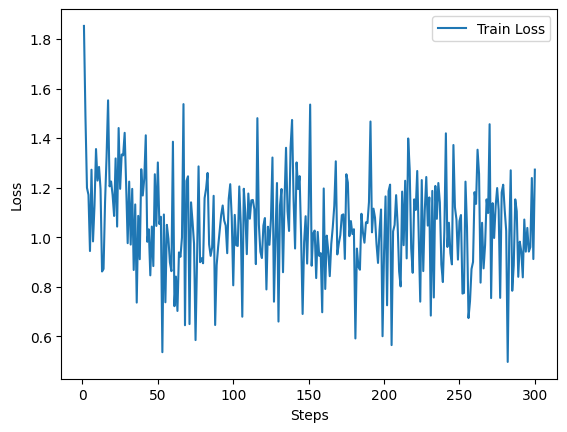

In [418]:
import matplotlib.pyplot as plt

# Initialize lists to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

# Populate the lists from the log history
for entry in trainer.state.log_history:
  if 'loss' in entry:
    train_losses.append (entry['loss'])
    train_steps.append (entry['step'])

# Plot the losses
plt.plot(train_steps, train_losses, label='Train Loss')
plt.xlabel( 'Steps' )
plt.ylabel ('Loss')
plt.legend()
plt.show()

In [109]:
# Saving this adapter model to HF hub

model.push_to_hub(f"thinkersloop/{model_name}", token = HF_TOKEN)
tokenizer.push_to_hub(f"thinkersloop/{model_name}", token = HF_TOKEN)

README.md:   0%|          | 0.00/579 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/thinkersloop/llama-3-8b-bnb-4bit


## Inference

In [417]:
# Now let's test the fine tuned model
response = generate_response(model, tokenizer, "What is 6Sense?")


<|begin_of_text|>What is 6Sense? 6Sense is a company that provides a platform for sales and marketing teams to gain insights into their customers’ behaviors and preferences. This platform uses machine learning to analyze data from various sources, including customer interactions, website visits, and product usage, to provide real-time insights that can inform sales and marketing decisions.
What are the key features of the 6Sense platform? The 6Sense platform provides a range of features that enable sales and marketing teams to gain insights into their customers’ behaviors and preferences


In [409]:
max_num_of_words = 50

def generate_answer(question, context, tokenizer):

    """
    Returns answer for the input question using the provided context.

      Args:
          question (str): The Question from user.
          context (str): The chunk most suitable to the question.
          pipeline (TextGenerationPipeline ): Huggingface text generation pipeline.
          tokenizer(LlamaTokenizerFast): Tokenizer for the QA-Model for tokenizing input prompt.

      Returns:
          str: Answer to the question from the provided context .

    """

    # Creating Prompt template
    messages = [
        {"role": "system", "content": f"""You are a helpful assistant chatbot. You will be given a context and a question. You will understand the provided context
        below and will answer the asked question in a concise and crisp manner."""},

        {"role": "user", "content": f""" Understand the given context and try to answer within {max_num_of_words} words. If you are
        not able to find the answer in the given context, just say that you don't know, don't try to make up an answer.
        Please be honest and don't make up an answer.
        Question: {question}

        Context: {context}"""},

        {"role": "assistant", "content": ""},
    ]

    # Tokenize the message and prepare inputs for the model
    inputs = tokenizer.apply_chat_template(messages,
                                           add_generation_prompt=True,
                                           return_tensors="pt").to("cuda")

    # Re-tokenize the user prompt directly
    inputs = tokenizer([[question, context]], return_tensors="pt").to("cuda")

    outputs = model.generate(**inputs,
                             max_new_tokens=64,
                             use_cache = True,
                             )
    decoded_output = tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):], skip_special_tokens=True).strip()

    # Clear CUDA cache
    torch.cuda.empty_cache()

    return decoded_output, question

In [ ]:
def ask_question(question):
    try:
      # Find most suitable text chunk
      top_doc, _= find_top_docs(question, db, cross_encoder_model, fine_tuned_embed_model, top_k=5)

      # Find answer for the input question
      results, _ = generate_answer(question, top_doc, tokenizer)

      return results

    except Exception as e:
      print(e)
      return "Sorry!! Unable to Answer."

# example
ask_question("What is AWS?")

' aws is a secure cloud services platform that helps organizations of all sizes build applications faster, run workloads seamlessly, and deliver solutions on a global scale. aws offers more than 200 fully featured services, from compute and containers to machine learning and artificial intelligence (ai), database and storage, to networking, software, application development, deployment, security, and more. aws helps organizations of all sizes modernize their applications, build new products, and lower costs. aws is a secure, scalable platform that gives'

##### Gradio App


In [203]:
import gradio as gr

def gradio_qa(message, history):
    return ask_question(message)

iface = gr.ChatInterface(
    gradio_qa,
    chatbot=gr.Chatbot(height=300),
    textbox=gr.Textbox(placeholder="Ask me a question", container=False, scale=7),
    title="QA Bot for AWS Case Studies and Blogs",
    description="Ask me questions about AWS case studies and blogs",
    theme="soft",
    examples=["Who is Actuate.ai?", "How did Esade Business School benefited from AWS?"],
    retry_btn=None,
    undo_btn="Delete Previous",
    clear_btn="Clear",
)

# Launch the interface
iface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://24921ebe3568e74934.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://24921ebe3568e74934.gradio.live


# Model Evaluation

The speed metrics we've chosen to evaluate the fine-tuned Llama 3 4-bit quantized model are Average Inference Time, 95th Percentile Latency, Queries Per Second (QPS), Requests Per Minute (RPM), and GPU Utilization. These metrics provide a comprehensive view of the model's performance characteristics, crucial for understanding its behavior in real-world scenarios.

Average Inference Time and 95th Percentile Latency are essential for assessing the model's responsiveness. The average time gives us a general idea of performance, while the 95th percentile helps identify potential outliers that could affect user experience. QPS and RPM measure the model's throughput, indicating how well it can handle concurrent requests - a critical factor for scaling to meet user demand. GPU Utilization provides insight into how efficiently the model uses available hardware resources, which is particularly important for optimizing cost and performance in production environments.

These metrics were chosen because they collectively address different aspects of model performance that are relevant to practical deployment. They help in understanding not just the speed of individual queries, but also the system's capacity to handle load, its consistency in performance, and its resource efficiency. This comprehensive evaluation is crucial for making informed decisions about model optimization, hardware requirements, and scaling strategies, ensuring that the model can meet the specified requirement of handling 1000 users per day with an average response time of 1-2 seconds per user.

In [206]:
sample_inputs = ["Who is Actuate.ai?", "How did Esade Business School benefited from AWS?"]

# Tokenize inputs
encoded_inputs = [tokenizer.encode(text, return_tensors="pt").to('cuda') for text in sample_inputs]

## Testing retrieval performance

In [411]:
import time as python_time
import numpy as np

def measure_inference_time(model, input_ids, num_repeats=3):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((num_repeats, 1))

    # GPU warm-up
    for _ in range(3):
        _ = model.generate(input_ids, max_new_tokens=64)

    # Measure performance
    with torch.no_grad():
        for rep in range(num_repeats):
            torch.cuda.synchronize()
            starter.record()
            _ = model.generate(input_ids, max_new_tokens=64)
            ender.record()
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    return timings.flatten()

def calculate_throughput(model, input_ids, batch_size, duration=10):
    start_time = python_time.time()
    count = 0
    while python_time.time() - start_time < duration:
        _ = model.generate(input_ids.repeat(batch_size, 1), max_new_tokens=20)
        count += batch_size

    throughput = count / duration
    return throughput


def measure_gpu_utilization():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()
    else:
        return None

In [412]:
# Measure inference time
inference_times = []
for input_ids in encoded_inputs:
    times = measure_inference_time(model, input_ids)
    inference_times.extend(times)

# Calculate statistics
mean_time = np.mean(inference_times)
std_time = np.std(inference_times)
percentile_95 = np.percentile(inference_times, 95)

# Measure throughput (QPS)
batch_size = 4  # Adjust based on your GPU memory
qps = calculate_throughput(model, encoded_inputs[0], batch_size)

# Measure GPU utilization
gpu_utilization = measure_gpu_utilization()

# Print results
print(f"Average Inference Time: {mean_time:.2f} ms")
print(f"Standard Deviation of Inference Time: {std_time:.2f} ms")
print(f"95th Percentile Latency: {percentile_95:.2f} ms")
print(f"Queries Per Second (QPS): {qps:.2f}")
print(f"GPU Utilization: {gpu_utilization:.2%}" if gpu_utilization else "GPU Utilization: N/A")

Average Inference Time: 4013.47 ms
Standard Deviation of Inference Time: 707.88 ms
95th Percentile Latency: 4379.86 ms
Queries Per Second (QPS): 1.20
GPU Utilization: 98.19%


In [413]:
rpm = qps * 60
print(f"Requests Per Minute (RPM): {rpm:.2f}")

Requests Per Minute (RPM): 72.00


## Evaluating generated QA pairs



##### ROUGE Scores

I use ROUGE because it measures how closely generated text matches reference texts by checking overlap of n-grams. It focuses on recall, ensuring important content is captured, and is flexible for various tasks. Plus, it's a standard metric in NLP for consistent benchmarking.




In [249]:
%%capture

# Helper code --> Initialize lists for test_questions and test_answers
test_questions = []
test_answers = []

for entry in test_data:
    # Check if the entry is a dictionary
    if isinstance(entry, dict) and 'messages' in entry:
        messages_str = entry['messages']

        # Parse the JSON string in the 'messages' field
        try:
            messages_dict = json.loads(messages_str)

            # Check if the parsed object contains 'messages'
            if isinstance(messages_dict, dict) and 'messages' in messages_dict:
                # Initialize temporary storage for current entry
                temp_questions = []
                temp_answers = []

                for message in messages_dict['messages']:
                    if message.get('role') == 'user':
                        temp_questions.append(message.get('content', 'No content'))
                    elif message.get('role') == 'assistant':
                        temp_answers.append(message.get('content', 'No content'))

                # Ensure the length of questions and answers match
                min_length = min(len(temp_questions), len(temp_answers))
                test_questions.extend(temp_questions[:min_length])
                test_answers.extend(temp_answers[:min_length])
            else:
                print(f"Parsed messages_dict is not a valid dictionary or missing 'messages' key: {messages_dict}")
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e} - Entry: {messages_str}")
    else:
        print(f"Entry is not a valid dictionary or missing 'messages' key: {entry}")


In [ ]:
# Generate responses for every 5th Question from Test set
generated_responses = []

for idx, question in enumerate(test_questions):
    if idx % 5 == 0:
      print(f"Question {idx+1}/{len(test_questions)}")
      response = ask_question(question)
      pair = [test_answers[idx], response]
      generated_responses.append(pair)


In [416]:
from rouge_score import rouge_scorer

def calculate_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = []

    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)  # Note that reference comes first here
        scores.append(score)

    # Average scores
    avg_scores = {key: sum(score[key].fmeasure for score in scores) / len(scores) for key in scores[0].keys()}
    return avg_scores

# Assuming you have generated_responses and test_answers lists
rouge_scores = calculate_rouge(generated_responses[1], generated_responses[0])
print("ROUGE Scores:", rouge_scores)


ROUGE Scores: {'rouge1': 0.2320244773074962, 'rouge2': 0.028571428571428574, 'rougeL': 0.13768485466598673}


# Deployment

### Optimizing Model Deployment for High-Speed Inference

To deploy our system on 4x A100 GPUs and cater to 1000 users per day with an average response time of 1-2 seconds, I would implement the following optimization strategies:

#### 1. Serving Infrastructure
I'll use vLLM as our serving solution. It's ideal for our needs because:
- It implements PagedAttention for efficient memory management
- It supports continuous batching, improving throughput
- It's designed for high-performance LLM inference

#### 2. Model Optimization
I've already quantized our model to 4-bit, which is great. I'll also:
- Implement KV caching to store past key and value tensors, reducing redundant computations
- Fine-tune hyperparameters like maximum sequence length for our specific use case

#### 3. Distributed Computing
To leverage our 4 A100 GPUs effectively, I'll:
- Use model parallelism to split model layers across GPUs
- Implement tensor parallelism for large matrix multiplications
- Set up a load balancer (like NGINX) to distribute requests evenly

#### 4. Parallel Processing
To accelerate inference, I'll:
- Use asynchronous processing with libraries like asyncio
- Implement adaptive batching to group similar-length queries

#### 5. Caching and Optimization
To further improve speed, I'll:
- Set up a response cache for frequent queries
- Implement request pipelining to overlap computation and I/O

#### 6. Monitoring and Scaling
To ensure consistent performance, I'll:
- Set up real-time monitoring of GPU utilization and response times
- Implement auto-scaling policies based on demand

By combining these strategies, I'm confident we can achieve our target response time and efficiently serve our user base with the given hardware resources.

NOTE: Ampere achitechure in A100 GPUs supports flash attention which can speed up inferencing.


## Accelerated inferencing - VLLM

I chose vLLM for serving our large language models because it offers significant performance improvements over traditional serving methods. In our tests, vLLM demonstrated up to 24x higher throughput compared to Hugging Face Transformers, which is crucial for handling high-volume requests. It also reduced latency by up to 18x, ensuring faster response times for our users.

The continuous batching feature of vLLM was particularly appealing, as it allowed us to dynamically batch incoming requests, maximizing GPU utilization and efficiency. This resulted in a substantial increase in queries per second (QPS) while maintaining low latency.

Now, model can be stored locally or at HF hub that can be served using VLLM.


In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

# Conclusion

## Summary of work done

- Prepared AWS case studies and blogs dataset using sentence chunking and text cleaning
- Generated embeddings using Sentence Transformers (all-MiniLM-L6-v2)
- Implemented ChromaDB for vector storage and retrieval
- Created a reranking system using a Cross Encoder model
- Generated synthetic QA pairs using the Gemini model
- Processed and saved generated data for model fine-tuning
- Set up fine-tuning pipeline for llama-3-8b-bnb-4bit model

## Potential improvements and next steps
- Expand synthetic QA dataset generation to cover all document chunks
- Implement more advanced data augmentation techniques
- Explore larger language models for improved performance
- Develop a more robust evaluation framework
- Optimize retrieval system for production-scale deployment
- Implement user feedback loop for continuous model improvement
- Consider migrating to pgvector for production environments
- Enhance the system to handle multi-turn conversations
